# Robustness of image classifier

Implementations and extensions of algorithms and experiments presented in [1] and [2] about robustness of neural network classifiers.

In section 1, we observe the decision boundaries of a classifier around images, and we measure the curvatures of the decision boundaries.

In section 2, we perform experiments to verify empirically the path-connectedness of decision regions.

References:

[1] Seyed-Mohsen Moosavi-Dezfooli, Alhussein Fawzi, Jonathan Uesato, and Pascal
Frossard. 2019. Robustness via Curvature Regularization, and Vice Versa. In
2019 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR).
9070-9078. https://doi.org/10.1109/CVPR.2019.00929

[2] Alhussein Fawzi, Seyed-Mohsen Moosavi-Dezfooli, Pascal Frossard, and Stefano
Soatto. 2018. Empirical Study of the Topology and Geometry of Deep Networks. In
2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition. 3762-3770.
https://doi.org/10.1109/CVPR.2018.00396


Images used are from the Tiny ImageNet dataset: http://cs231n.stanford.edu/tiny-imagenet-200.zip

## Imports and load pretrained VGG model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib
from matplotlib.patches import Patch

from PIL import Image
from torchvision import transforms

from sklearn.decomposition import PCA

import os

import pandas as pd

Load the model and download the class labels


In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
if torch.cuda.is_available():
    model.to('cuda')
model.eval()

--2023-12-10 21:22:09--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-12-10 21:22:09 (91.8 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:06<00:00, 83.0MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
if torch.cuda.is_available():
    model.to('cuda')

## Definition of the functions

### Read and display

In [ ]:
def get_torch_image(filename, to_cuda=False):
    """
    Open the image at filename and returns the preprocessed torch tensor
    """
    img = Image.open(filename)
    img = preprocess(img)
    if to_cuda and torch.cuda.is_available():
      img = img.to('cuda')
    return img

def predict(torch_img, return_max_label=False):
    """
    Apply the model on an image and returns the class probabilities
    If 'return_max_label' is True, only returns the name of the
    class with the highest score
    """
    input_batch = torch_img.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    if return_max_label:
      return categories[torch.argmax(probabilities)]

    return probabilities

def plot_torch_image(img):
    """
    Show the image represented by the tensor 'img'
    """
    # Scale the normalized image to the original range
    inv_shift = transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])
    inv_scale = transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225])
    scaled_img = inv_shift(inv_scale(img))

    plt.imshow(scaled_img.transpose(0, 2).transpose(0, 1))
    plt.show()

# Preprocessing function to normalize the input images
preprocess = transforms.Compose([
    transforms.Resize(256, antialias=True),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Adversarial images and decision boundaries

In [ ]:
def adversarial_image(img, target_label=None, step_size=2e-2, linesearch=True,
                      eps=1e-2, max_iter_line_search=100, verbose=False):
    """
    Searches an adversarial image close to 'img'
    a target_label can be specified, otherwise the
    class with the second highest probability is chosen
    """
    # First forward pass to know the predicted class
    init_input = img.unsqueeze(0)
    input_tensor = img.unsqueeze(0)
    if torch.cuda.is_available():
        init_input = init_input.to('cuda')
        input_tensor = input_tensor.to('cuda')
    with torch.no_grad():
        output = model(input_tensor)

    #
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    ref_class = torch.argmax(probabilities)

    # Determines the target class
    fixed_target = True
    if target_label is None:
        target_label = torch.topk(probabilities, 2)[1][1]
        fixed_target = False

    # Gradient ascent
    input_tensor.requires_grad = True
    k = 0

    while torch.argmax(probabilities) != target_label:
      if not fixed_target:
        # Update the target
        target_label = torch.topk(probabilities, 2)[1][1]

      input_tensor.grad = None

      output = model(input_tensor)
      probabilities = torch.nn.functional.softmax(output[0], dim=0)
      target_prob = probabilities[target_label]
      grad = input_tensor.grad
      target_prob.backward()

      # Update the input image
      grad = input_tensor.grad
      with torch.no_grad():
          # normalize gradient
          grad = step_size*grad / torch.norm(grad)
          # apply to the input
          input_tensor.add_(grad)

      k += 1
    if verbose:
      print("Found in {} steps, distance to origin: {}".format(k, torch.norm(input_tensor-init_input)))

    if not linesearch:
      return input_tensor

    # Dichotomic linesearch to minimize the distance to the original image
    def is_adversarial(t):
        """
        Check if the image parametrized by 0 < t < 1 on the segment
        between the initial image and the adversarial one has the target label
        """
        img =  t * input_tensor + (1-t) * init_input
        pred = torch.argmax(model(img))
        if fixed_target:
          return pred == target_label

        return pred != ref_class

    # Coordinate of the adversarial image on the segment between the two images
    t = (k-1)/k
    t_min = 0
    t_max = 1

    iter_line_search = 0

    while t_max - t_min > eps and iter_line_search < max_iter_line_search:
        if is_adversarial(t):
          t_max = t
        else:
          t_min = t
        t = (t_min + t_max) / 2

        iter_line_search += 1

    input_tensor = t_max * input_tensor + (1-t_max) * init_input

    if verbose:
      print("After {} line search iterations, distance to origin: {}".format(iter_line_search,
                                                                          torch.norm(input_tensor-init_input)))
      print("Class of the adversarial image:", target_label, categories[target_label])

    return input_tensor



In [ ]:
def plot_binary_regions(orig, adv, scale=2, dir=None, n1=15, n2=15):
    """
    Display the decision regions on a 2D square of the input space
    centered at 'orig' and along directions.
    The vertical axis is the direction of the adversarial image 'adv'
    The second direction is 'dir', which is chosen as a random orthogonal
    directoin by default
    'n1' and 'n2' define the number of points sampled along each direction
    'scale' defines the scale of the figure
    """
    class_pred = np.zeros(n1*n2, dtype='int')

    u = (adv - orig).cpu().detach().numpy()
    dist = np.linalg.norm(u)
    u = u / dist

    if dir is None:
        # Generate a random unit vector orthogonal to u
        dir = torch.randn(orig.shape)
        dir = dir - torch.sum(dir*u)*u # Project orthogonaly to u
        dir = dir / torch.norm(dir)


    # Predict the labels line by line
    for i, c in enumerate(np.linspace(-dist*scale, dist*scale, n1)):
      batch = segment_to_batch(orig + u*c - dist*scale*dir,
			       orig + u*c + dist*scale*dir,
			       N=n2)

      with torch.no_grad():
          output = model(batch).cpu().numpy()
      class_pred[i*n2: (i+1)*n2] = output.argmax(axis=-1)

    # Predict the label for original image
    batch = orig.view(1, orig.shape[0], orig.shape[1], orig.shape[2])
    if torch.cuda.is_available():
        batch = batch.to('cuda')
    class_ref = model(batch).argmax().cpu().numpy().reshape(1)

    to_plot = class_pred==class_ref
    labels = ["Original class", "Other classes"]

    cmap = matplotlib.colormaps["viridis"]

    plt.imshow(to_plot.reshape(n1, n2))#, cmap=cmap)

    curv = curvature(orig, adv)
    print(curv, torch.norm(dir).numpy())

    # Affine transform to scale to the figure coordinates
    a_1 = (n1-1)/(2*dist*scale)
    b_1 = (n1-1)/2
    a_2 = (n2-1)/(2*dist*scale)
    b_2 = (n2-1)/2

    xx = np.linspace(-dist*scale, dist*scale, n1)
    yy = dist + 0.5*curv*(xx*torch.norm(dir).numpy())**2

    xx = a_2*xx + b_2
    yy[np.abs(yy) > dist*scale] = np.nan
    yy = a_1*yy + b_1
    plt.plot(xx, yy)


    plt.ylabel("First direction")
    plt.yticks(ticks=np.linspace(0, n1-1, 9),
              labels=np.round(np.linspace(-dist*scale, dist*scale, 9), 2))
    plt.xlabel("Second direction")
    plt.xticks(ticks=np.linspace(0, n2-1, 9),
              labels=np.round(np.linspace(-dist*scale, dist*scale, 9), 2))

    plt.gca().invert_yaxis()

    patches = [Patch(facecolor=cmap(255*(1-i)),
                     label=labels[i])
               for i in range(2)]

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.show()

In [ ]:
def hessian(img, dir=None, scale=1e-2, verbose=False):
    """
    Gives an estimate of the quantities z^T H z and z^T H² z = ||Hz||²
    where H is the hessian matrix of the loss function, and z is a direction
    that can be specified by 'dir', otherwise it is chosen randomly
    The 'scale' parameter defines the size of the hop in the finite difference
    """
    ref_class = torch.argmax(predict(img))
    ref_class = torch.cat((ref_class.view(1), ref_class.view(1)))

    if dir is None:
        dir = torch.randn(img.shape)

    dir = dir / torch.norm(dir)

    batch = segment_to_batch(img, img+dir*scale, N=2, requires_grad=True)
    batch.retain_grad()

    proba = torch.softmax(model(batch), dim=-1)
    criterion = torch.nn.CrossEntropyLoss()

    loss = criterion(proba, ref_class)

    loss.backward()

    hess_dir = (batch.grad[1] - batch.grad[0]).cpu() / scale

    zH2z = torch.norm(hess_dir)**2
    zHz = torch.sum(hess_dir*dir)
    return zHz.numpy(), zH2z.numpy()

In [ ]:
def plot_decision_regions(img, d1, d2, lim_1=(-1, 1), lim_2=(-1, 1), n1=15, n2=15, preprocess_img=False):
    """
    Display the decision regions on a 2D square of the input space
    centered at 'img' and along directions 'd1' and 'd2'
    'n1' and 'n2' define the number of points sampled along each direction
    'lim_1' and 'lim_2' are the bounds of the multiplicative coefficients applied
    to 'd1' and 'd2
    """
    torch_preprocess = transforms.Compose([
    transforms.Resize(256, antialias=True),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    class_pred = np.zeros(n1*n2, dtype='int')

    # Predict the labels line by line
    for i, c1 in enumerate(np.linspace(lim_1[0], lim_1[1], n1)):
      batch = torch.zeros(n2, img.shape[0], img.shape[1], img.shape[2])

      if torch.cuda.is_available():
          batch = batch.to('cuda')

      for j, c2 in enumerate(np.linspace(lim_2[0], lim_2[1], n2)):
        img_test = img + d1*c1 + d2*c2
        if preprocess_img:
          img_test = torch_preprocess(img_test)
        batch[j] = img_test

      with torch.no_grad():
          output = model(batch).cpu().numpy()
      class_pred[i*n2: (i+1)*n2] = output.argmax(axis=-1)

    # Predict the label for img
    batch = img.view(1, img.shape[0], img.shape[1], img.shape[2])
    if torch.cuda.is_available():
        batch = batch.to('cuda')
    class_ref = model(batch).argmax().cpu().numpy().reshape(1)

    # Extract the different classes predicted
    present_classes = np.unique(np.concatenate((class_ref, class_pred)))


    to_plot = np.zeros(class_pred.shape)
    labels = ["-"]*len(present_classes)

    cmap = matplotlib.colormaps["tab10"]
    if len(present_classes) > 10:
      cmap = matplotlib.colormaps["tab20"]

    for i, cls in enumerate(present_classes):
        to_plot[class_pred==cls] = i
        labels[i] = categories[cls]

    plt.imshow(to_plot.reshape(n1, n2), cmap=cmap, vmin=0,
               vmax=9 if len(present_classes) <=10 else 19)

    plt.ylabel("First direction")
    plt.yticks(ticks=np.linspace(0, n1-1, 9),
              labels=np.linspace(lim_1[0], lim_1[1], 9))
    plt.xlabel("Second direction")
    plt.xticks(ticks=np.linspace(0, n2-1, 9),
              labels=np.linspace(lim_2[0], lim_2[1], 9))

    patches = [Patch(facecolor=cmap(i),
                     label=labels[i])
               for i in range(len(present_classes)) ]

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.show()


In [ ]:
def segment_to_batch(img_1, img_2, N=50, t_range=(0, 1), requires_grad=False):
    """
    Returns a tensor representing a batch of images regularly sampled
    on the line between img_1 and img_2,
    't_range' specifies the range of the image parameters, where 0 corresponds
    to img_1 and 1 corresponds to img_2
    """
    batch = torch.zeros(N, img_1.shape[0], img_1.shape[1], img_1.shape[2],
                        requires_grad=requires_grad)

    if torch.cuda.is_available():
        batch = batch.to('cuda')

    for i, t in enumerate(np.linspace(t_range[0], t_range[1], N)):
        batch[i] = img_1*(1-t) + img_2*t

    return batch

def curvature(orig, adv, dir=None, N=10, scale=1e-2, h=1e-2, verbose=False):
    """
    Estimates the curvature of the decision boundary at 'adv' along the
    direction 'dir' (random by default), using the soft binary classifiers
    that only takes into consideration the original and adversarial classes
    """
    orig_class = torch.argmax(predict(orig))
    adv_class = torch.argmax(predict(adv))

    def soft_binary_clf(batch):
      logits = model(batch)

      # Take the logits corresponding to the 2 classes
      logit_orig = logits[:, orig_class]
      logit_adv = logits[:, adv_class]

      return 1 / (1 + torch.exp(logit_orig-logit_adv))

    # Normal direction to the decision boundary
    u = adv - orig
    u = u / torch.norm(u)

    # Sample N images along the direction of u and pass them through the soft classifier
    prob = soft_binary_clf(segment_to_batch(adv-u*scale,
                                            adv+u*scale,
                                            N=N))
    prob = prob.cpu().detach().numpy().reshape(-1)

    # Fit a linear regression on these values
    tt = np.linspace(-scale, scale, N)
    poly_features = np.array([np.ones(N), tt]).T
    sigma = np.linalg.inv(poly_features.T @ poly_features)
    mu = sigma @ poly_features.T @ prob

    b, a = mu # Intercept and slope
    grad_u = a

    if verbose:
      plt.plot(tt, prob)
      plt.plot(tt, a*tt + b)
      plt.show()
      print("grad u: a={}, b={}".format(a,b))

    # Compute the second derivative along the other direction
    if dir is None:
        # Generate a random unit vector orthogonal to u
        dir = torch.randn(orig.shape)
        dir = dir - torch.sum(dir*u)*u # Project orthogonaly to u

    dir = dir / torch.norm(dir)

    # Sample N images along the direction dir and pass them through the soft classifier
    prob = soft_binary_clf(segment_to_batch(adv-dir*scale,
                                            adv+dir*scale,
                                            N=N))
    prob = prob.cpu().detach().numpy().reshape(-1)

    # Fit a second order polynomial regression
    tt = np.linspace(-scale, scale, N)
    poly_features = np.array([np.ones(N), tt, tt**2]).T
    sigma = np.linalg.inv(poly_features.T @ poly_features)
    mu = sigma @ poly_features.T @ prob
    c, b, a = mu
    grad_2_dir = a

    if verbose:
      plt.plot(tt, prob)
      plt.plot(tt, a*tt**2 + b*tt + c)
      plt.show()
      print("grad2 dir: a={}, b={}, c={}".format(a,b,c))

    # Deduce the curvature
    curvature = -grad_2_dir / grad_u
    #curvature = -0.5*grad_2_dir / grad_u**2

    return curvature


### Path finding - find a continuous path between two images of the input space, which remains always in the same decision region

In [ ]:
def nb_error_path(img_1, img_2, class_id=None, n_test_pts=10):
    """
    Returns the number of sampled images from the segment [img_1, img_2]
    that are not in the same class
    """
    batch = segment_to_batch(img_1, img_2, N=n_test_pts)
    class_pred = torch.argmax(model(batch), dim=-1)
    return torch.sum(class_pred != class_id)

def find_path(img_1, img_2, class_id=None, n_test_pts=10, depth=0, max_depth=5,
              step_size=1e-3, linesearch=True, eps=1e-1, verbose=False):
    """
    Recursively finds a path between img_1 and img_2 that always stays in the
    same prediction region
    """

    # As the function is recursive, we limit the recursion depth
    assert depth <= max_depth

    if class_id is None:
      class_id = torch.argmax(predict(img_1))

    assert class_id == torch.argmax(predict(img_1))
    assert class_id == torch.argmax(predict(img_2))

    # The path is represented by a list of images
    path_first_part = [img_1]
    path_second_part = []
    m = (img_1 + img_2) / 2

    # If the middle point is not correct, we find an image close to m
    # with the correct label using the adversarial method
    if torch.argmax(predict(m)) != class_id:
        m = adversarial_image(m, target_label=class_id, step_size=step_size,
                              linesearch=linesearch, eps=eps)[0].cpu().detach()
        path_second_part = [m]

    # Check if the path is correct
    nb_errors_1 = nb_error_path(img_1, m, class_id=class_id, n_test_pts=n_test_pts)
    nb_errors_2 = nb_error_path(m, img_2, class_id=class_id, n_test_pts=n_test_pts)
    if verbose:
        print("Depth {}, errors on each parts: {}, {}".format(depth, nb_errors_1, nb_errors_2))

    # If the path is not correct, recursively call the function to find paths
    # for the first or second half
    if nb_errors_1 > 0:
      path_first_part = find_path(img_1, m, class_id=class_id, n_test_pts=n_test_pts,
                                  depth=depth+1, max_depth=max_depth, step_size=step_size,
                                  linesearch=linesearch, eps=eps)

    if nb_errors_2 > 0:
      path_second_part = find_path(m, img_2, class_id=class_id, n_test_pts=n_test_pts,
                                   depth=depth+1, max_depth=max_depth, step_size=step_size,
                                   linesearch=linesearch, eps=eps)

    # Add the last image to the list
    if depth == 0:
      path_second_part = path_second_part + [img_2]

    return path_first_part + path_second_part


In [ ]:
def visualize_path(path):
    """
    Visualize the path on the first directions given by a PCA
    """
    path_tensor = torch.cat([img.unsqueeze(0) for img in path], dim=0).reshape(len(path), -1)
    print("Number of images in the path:", len(path))

    # Reduce the dimensionality
    pca = PCA(n_components=10)
    low_dim_path = pca.fit_transform(path_tensor)

    plt.scatter(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, color="black")
    plt.title("Explained ratio by component", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.yscale('log')
    plt.savefig("figures/pca_ratio.png")
    plt.show()

    print("Number of PCA dimensions:", pca.n_components_)

    distance_from_linear = np.zeros(len(path))

    u = path[-1] - path[0]
    u = u / torch.norm(u)
    # Store the PCA representations of the projections of the image on the linear
    # segment
    pca_projections = np.zeros((pca.n_components_, len(path)))

    for i, img in enumerate(path):
        # project img on the linear segment
        diff = img - path[0]
        diff = torch.sum(u*diff)*u
        img_proj = path[0] + diff
        distance_from_linear[i] = torch.norm(img_proj - img)
        pca_projections[:, i] = pca.transform(img_proj.view(1, -1))

    # Plot the representations of the path on different PCA projections
    for dim in range(1, 4):
        plt.figure(figsize=(8,8))
        plt.plot(low_dim_path[:, 0], low_dim_path[:, dim], color='black')
        plt.scatter(low_dim_path[:, 0], low_dim_path[:, dim], color="black")#, c=distance_from_linear)
        plt.title("Main direction vs. direction " + str(dim), fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.savefig("figures/dir_"+str(dim)+".png")
        plt.show()

    for i in range(1, len(path)-1):
        if distance_from_linear[i] > distance_from_linear[i-1]:
           if distance_from_linear[i] > distance_from_linear[i+1]:
              plot_torch_image(path[i])


def max_path_deviance(path):
    """
    Compute the maximum distance between images of the path and the linear
    segment between its extremities
    """

    deviance = np.zeros(len(path))
    u = path[-1] - path[0]
    u = u / torch.norm(u)

    for i, img in enumerate(path):
        # project img on the linear segment
        diff = img - path[0]
        diff = torch.sum(u*diff)*u
        img_proj = path[0] + diff

        deviance[i] = torch.norm(img_proj - img)

    return np.max(deviance)


# 1 - Observation of the decision boundaries

In this section, we study the decision regions defined by the neural network aroung an input image.

### Simple forward pass of an image

In [ ]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

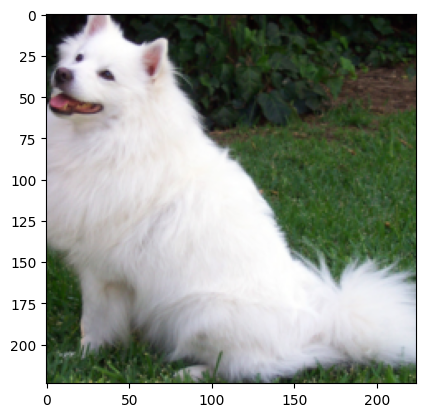

Samoyed 0.6673735976219177
Pomeranian 0.16195233166217804
Eskimo dog 0.017759378999471664
collie 0.017686229199171066
keeshond 0.01706553064286709


In [ ]:
# sample execution (requires torchvision)

input_image = Image.open(filename)
torch_image = preprocess(input_image)
input_batch = torch_image.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
#print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = F.softmax(output[0], dim=0)
#print(probabilities)

plot_torch_image(torch_image)

# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

## Plot the decision regions of the classifier on 2D projections of the input space around an image

### Around the dog image

In [ ]:
torch_image.min()

tensor(-2.1008)

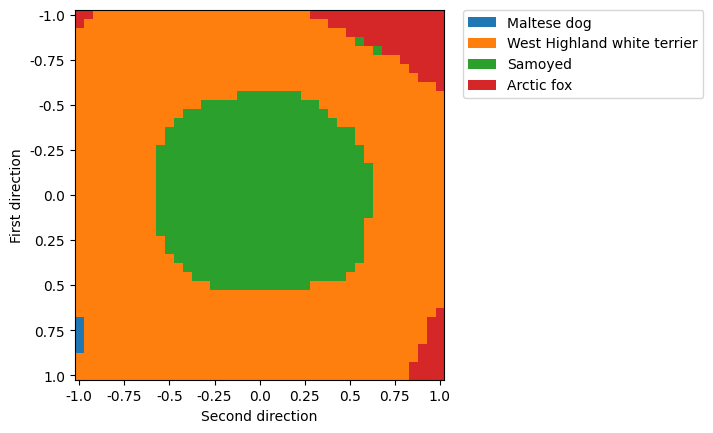

In [ ]:
torch.manual_seed(0)
d1 = torch.randn(torch_image.shape)
d2 = torch.randn(torch_image.shape)

#Normalisation
maxval = torch.max(torch_image).detach().cpu().item()
d1 = d1/(d1.max()*maxval)
d2 = d2/(d2.max()*maxval)

# Max perturbation of epsilon=
epsilon = 5
plot_decision_regions(torch_image, d1*epsilon, d2*epsilon, n1=41, n2=41, lim_1=(-1,1), lim_2=(-1,1))

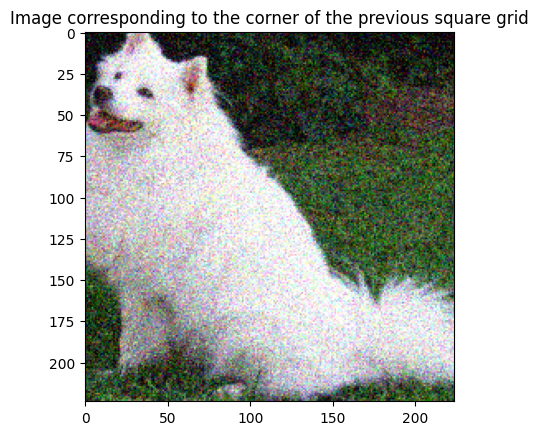

In [ ]:
plt.title("Image corresponding to the corner of the previous square grid")
plot_torch_image(torch_image - epsilon*(d1+d2))

### Around a white noise image

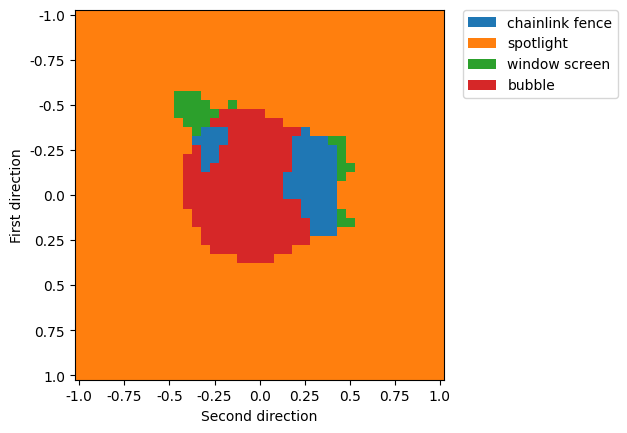

In [ ]:
torch.manual_seed(1)

noise = torch.randn(torch_image.shape)
d1 = torch.randn(torch_image.shape)
d2 = torch.randn(torch_image.shape)

#Normalisation
maxval = torch.max(torch_image).detach().cpu().item()
d1 = d1/(d1.max()*maxval)
d2 = d2/(d2.max()*maxval)
noise = noise * torch.norm(torch_image) / torch.norm(noise)

# Max perturbation of epsilon=
epsilon = 100
plot_decision_regions(noise, d1*epsilon, d2*epsilon, n1=41, n2=41, lim_1=(-1,1), lim_2=(-1,1))

## Decision regions for linear interpolations between two images

### Two images with the same label

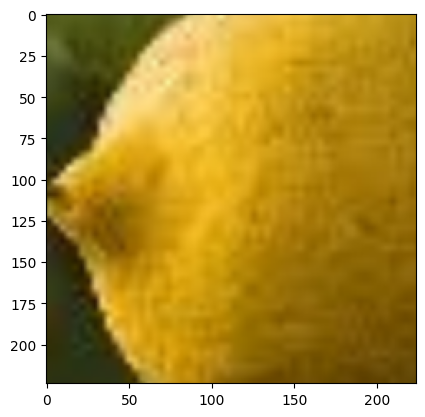

lemon


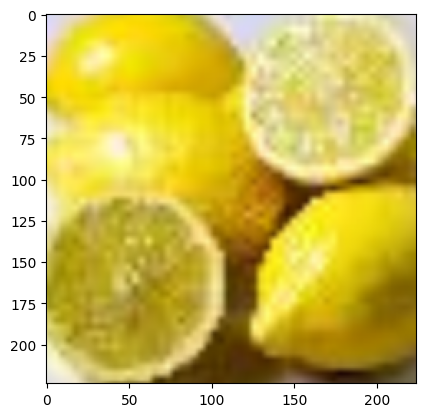

lemon


In [ ]:
lemon_1 = get_torch_image("lemon_1.JPEG")
plot_torch_image(lemon_1)
print(predict(lemon_1, return_max_label=True))

lemon_2 = get_torch_image("lemon_2.JPEG")
plot_torch_image(lemon_2)
print(predict(lemon_2, return_max_label=True))

### Lemon regions

The first direction of the plot is the direction of the difference between the two images (located at $\pm 1$), the other direction is given by random noise

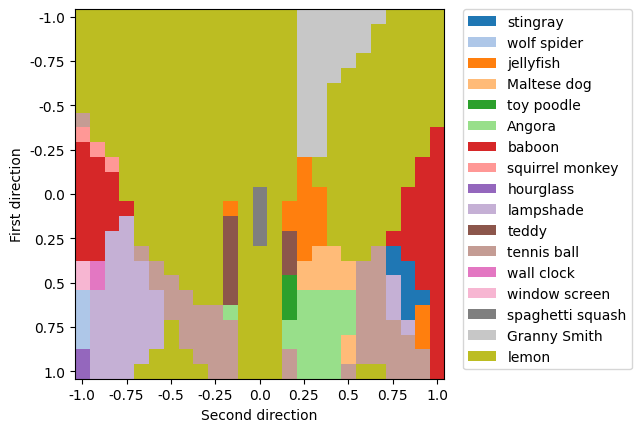

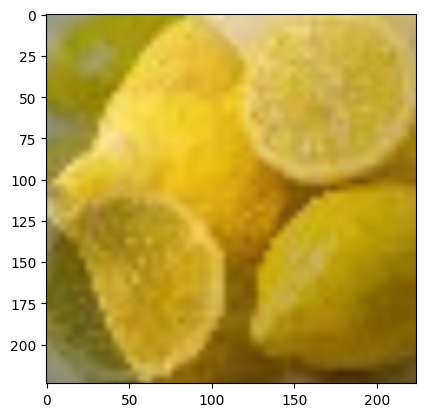

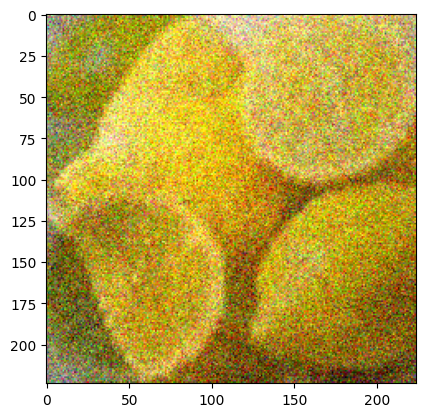

In [ ]:
torch.manual_seed(0)

linear_interp_lemons = (lemon_1 + lemon_2) / 2

dir_lemons = (lemon_1 - lemon_2) / 2
dir_noise = torch.randn(lemon_1.shape)
dir_noise = dir_noise*torch.norm(dir_lemons)/torch.norm(dir_noise)

plot_decision_regions(linear_interp_lemons, dir_lemons, dir_noise, n1=25, n2=25)

plot_torch_image(linear_interp_lemons)

plot_torch_image(linear_interp_lemons + dir_noise)


In [ ]:
predict(linear_interp_lemons + dir_lemons, return_max_label=True)

'lemon'

In [ ]:
predict(linear_interp_lemons, return_max_label=True)

'spaghetti squash'

## Generation of adversarial perturbations

We use the function ``` adversarial_image ``` which implements a gradient ascent method to find an image close to a reference one for the L2 norm, but with a different predicted label

In [ ]:
adv_lemon = adversarial_image(lemon_1, target_label=None).cpu()[0]

In [ ]:
print(adv_lemon.shape)
print(categories[predict(adv_lemon).argmax()])

torch.Size([3, 224, 224])
spaghetti squash


spaghetti squash


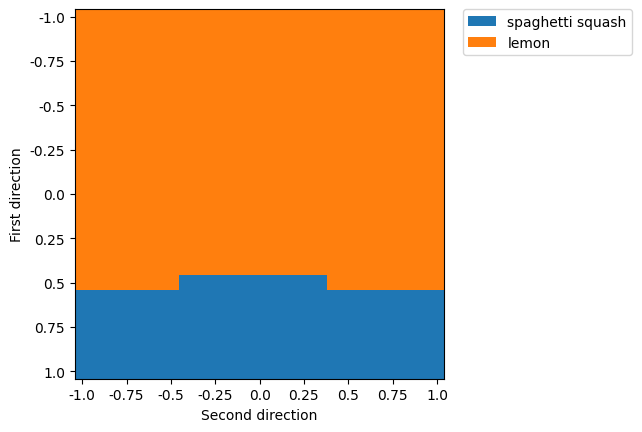

In [ ]:
dir_adv = adv_lemon - lemon_1

dir_noise = torch.randn(dir_adv.shape)
dir_noise = dir_noise*torch.norm(dir_adv)/torch.norm(dir_noise)

print(categories[predict(lemon_1 + dir_adv).argmax()])

plot_decision_regions(lemon_1, dir_adv*2, dir_noise*2, n1=25, n2=25)

## Curvature of the boudnaries

We compute the curvature of the decision boundaries along directions tangent to the boundary.

Plot the histogram of the estimated curvatures on 200 random tangent directions of the decision boundary between the lemon image and its adversarial perturbation

In [ ]:
curvatures = [curvature(lemon_1, adv_lemon) for k in range(200)]

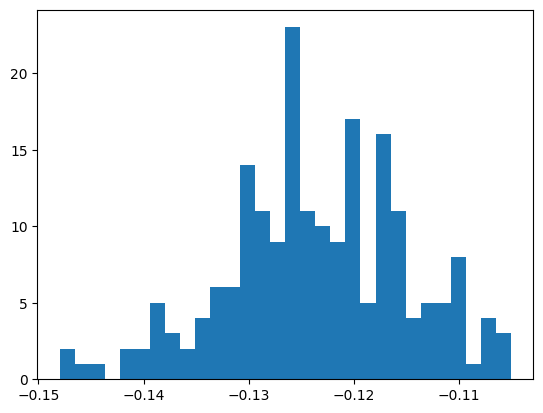

In [ ]:
plt.hist(curvatures, bins=30)
plt.show()

Visualize the parabola given by the estimated curvature

In [ ]:
dir = torch.randn(lemon_1.shape)
dir = dir / torch.norm(dir) * 10

0.056566729690959175 9.999997


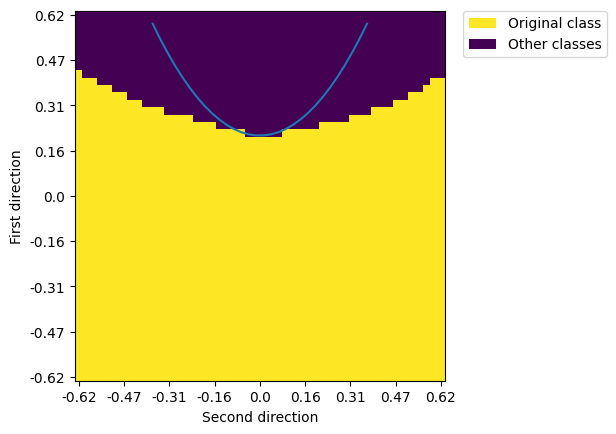

In [ ]:
plot_binary_regions(lemon_1, adv_lemon, dir=dir, scale=3, n1=50, n2=50)

0.0612369188529723 0.9999997


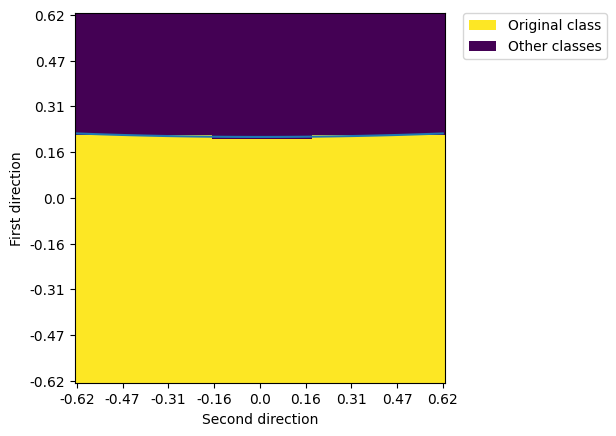

In [ ]:
plot_binary_regions(lemon_1, adv_lemon, scale=3, n1=100, n2=100)

In [ ]:
adv_lemon_2 = adversarial_image(lemon_2, target_label=None).cpu()[0]

0.06920536345501625 0.99999964


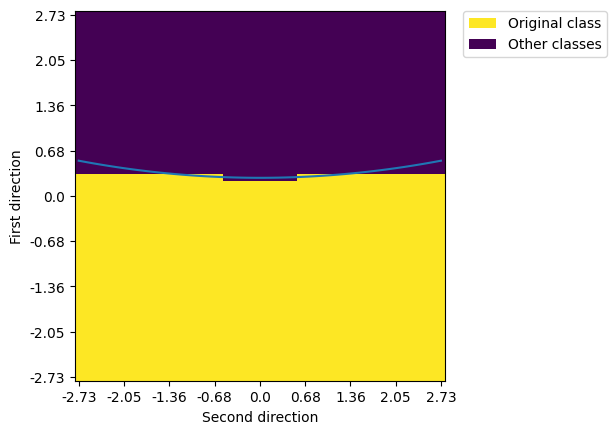

In [ ]:
plot_binary_regions(lemon_2, adv_lemon_2, scale=10, n1=50, n2=50)


Our measure of the curvature using the second derivatives of a local binary decision function does not seem to fit exactly the actual local curvature.
It remains unclear if this is due to numerical issues and to the instability of finite difference method at this scale, or if this is due to errors in the implementation.

# 2 - Experimental study of the path connectedness of decision regions

In this section, we reproduce experiments from [2] by implementing the path finding algorithm of the article.

As the authors, for two images classified similarly by the neural network, we find a continuous path of input images between them, which remains in the same decision region

## Find a path between two natural images of the same class

Find a path between two images that remain in the same region, the path is represented as a list of images

In [ ]:
path = find_path(lemon_1, lemon_2, max_depth=20, n_test_pts=100)

### Visualize the path with a PCA

In [ ]:
print(torch.norm(lemon_1-lemon_2))

tensor(520.9933)


In [ ]:
print(max_path_deviance(path))

0.022072618827223778


Number of images in the path: 38


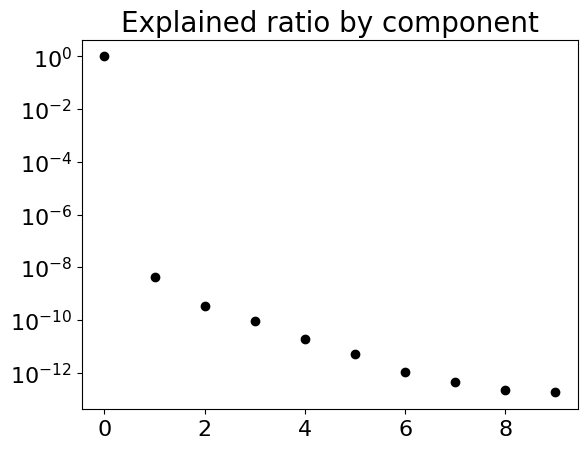

Number of PCA dimensions: 10


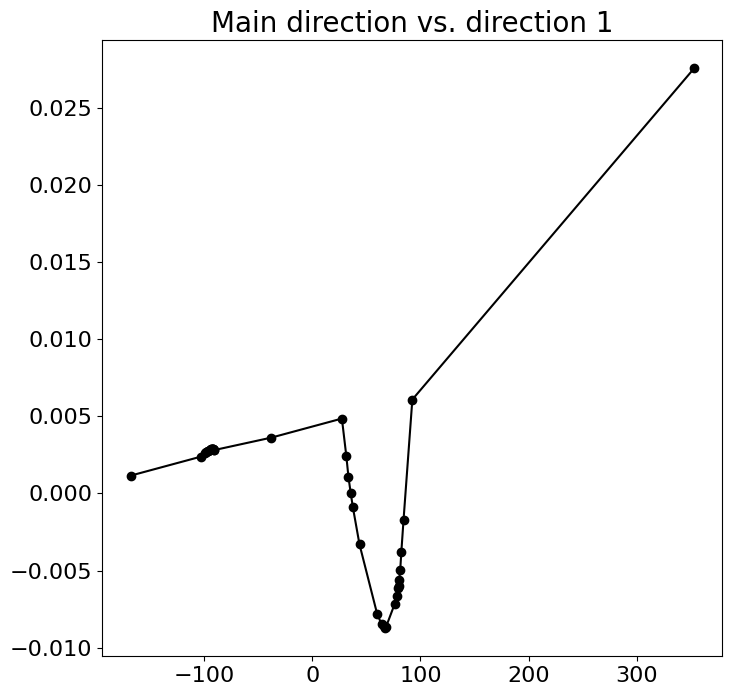

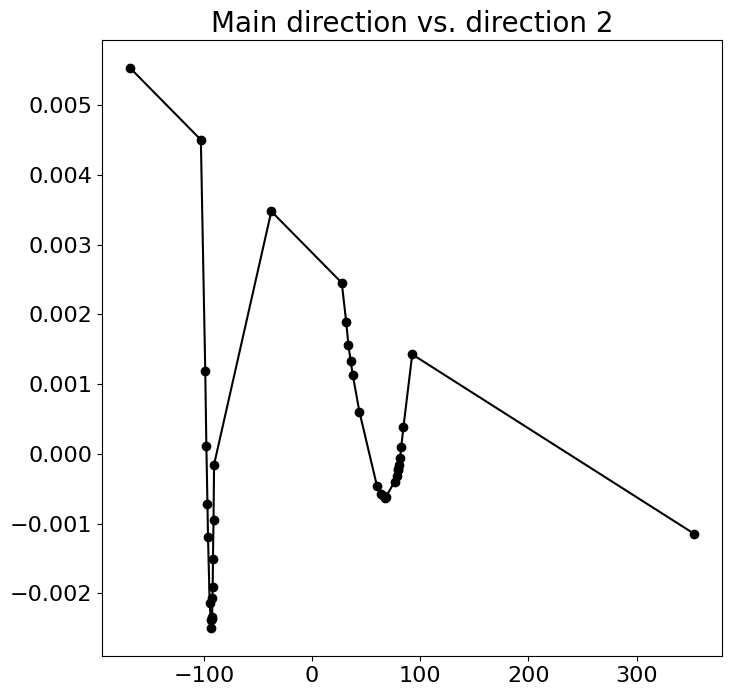

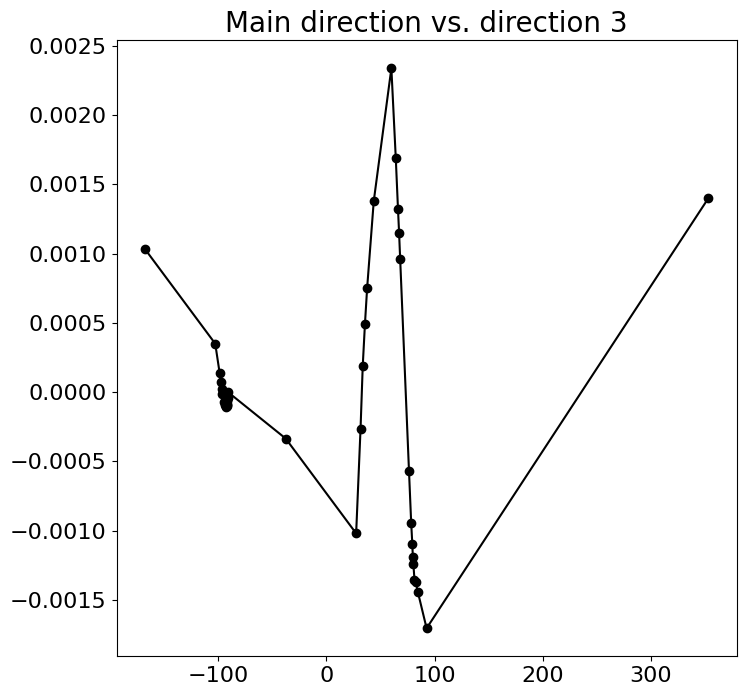

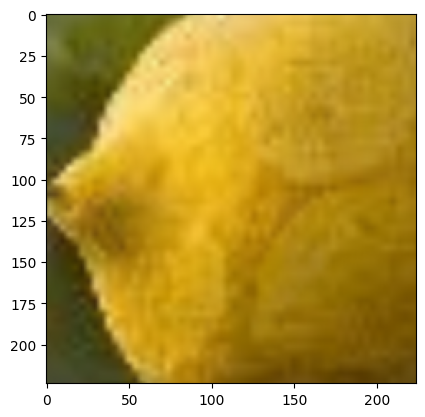

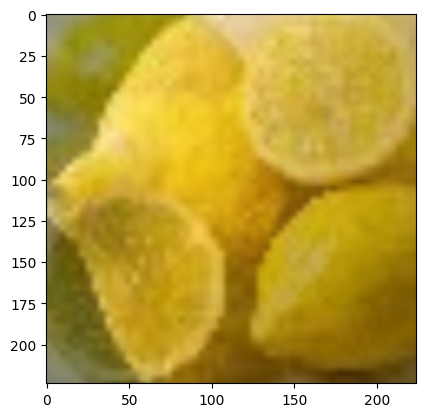

In [ ]:
visualize_path(path)

## Find a path between two adversarial images

We take different natural images that are not in the lemon class, and find for each of them an adversarial perturbation that is predicted as a lemon.
Then, we find paths that remains in the lemon regions between these adversarial images.

In [ ]:
fake_lemon_1 = adversarial_image(get_torch_image("test_images/test_9968.JPEG"), target_label=951)[0].cpu().detach()
fake_lemon_2 = adversarial_image(get_torch_image("test_images/test_9975.JPEG"), target_label=951)[0].cpu().detach()
fake_lemon_3 = adversarial_image(get_torch_image("test_images/test_9999.JPEG"), target_label=951)[0].cpu().detach()

In [ ]:
print(predict(fake_lemon_1, return_max_label=True))
print(predict(fake_lemon_2, return_max_label=True))
print(predict(fake_lemon_3, return_max_label=True))

lemon
lemon
lemon


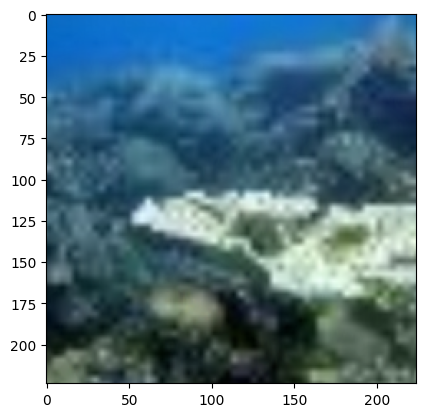

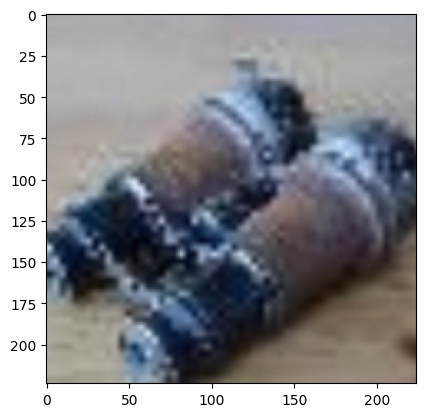

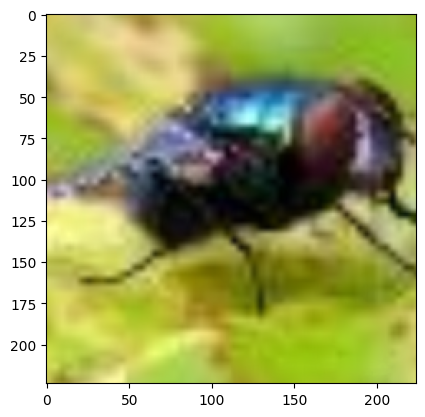

In [ ]:
plot_torch_image(fake_lemon_1.detach())
plot_torch_image(fake_lemon_2.detach())
plot_torch_image(fake_lemon_3.detach())

#### Find and visualize the path between the first and second adversarial lemon images

In [ ]:
path_fake_lemons_1_2 = find_path(fake_lemon_1, fake_lemon_2, max_depth=20,
                                 n_test_pts=100, step_size=1e-2, linesearch=False, eps=0.1)
print(max_path_deviance(path_fake_lemons_1_2))

1.9646552801132202


Number of images in the path: 42


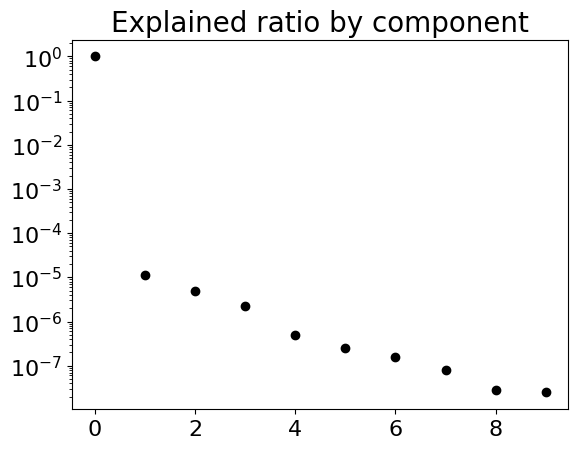

Number of PCA dimensions: 10


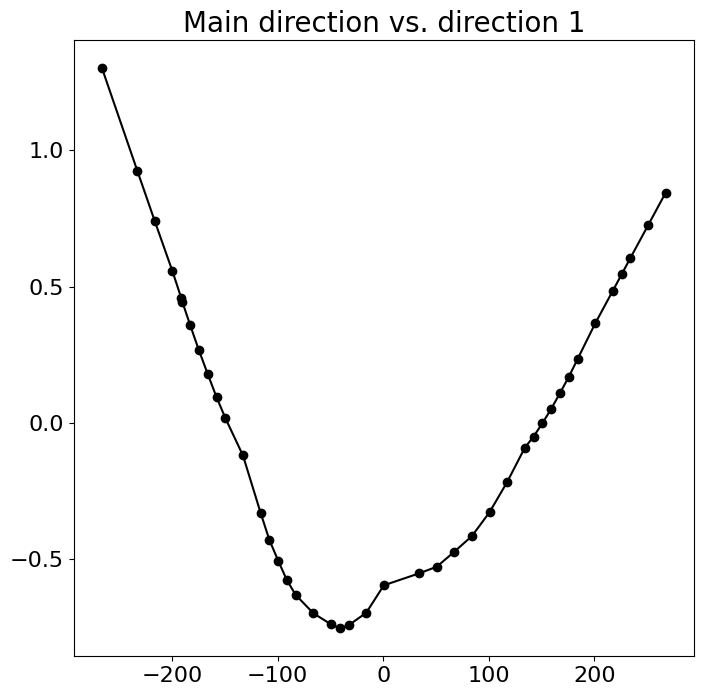

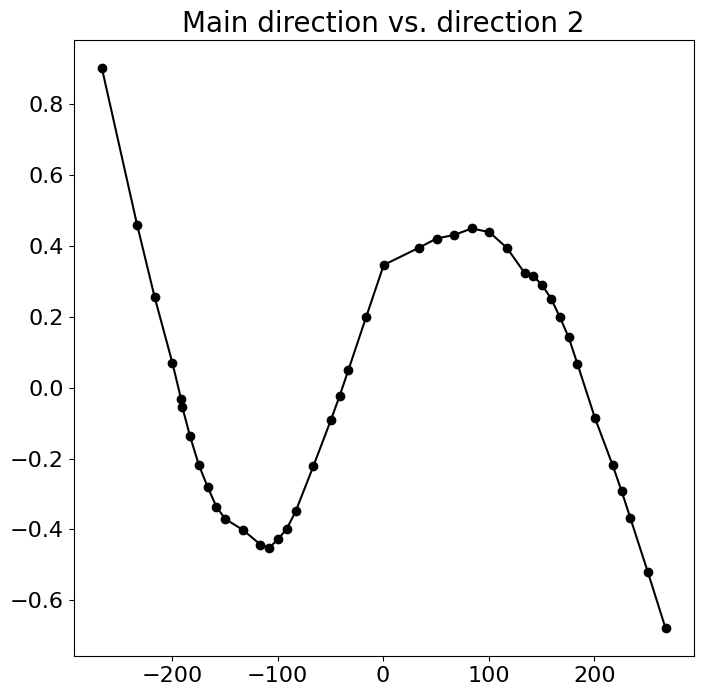

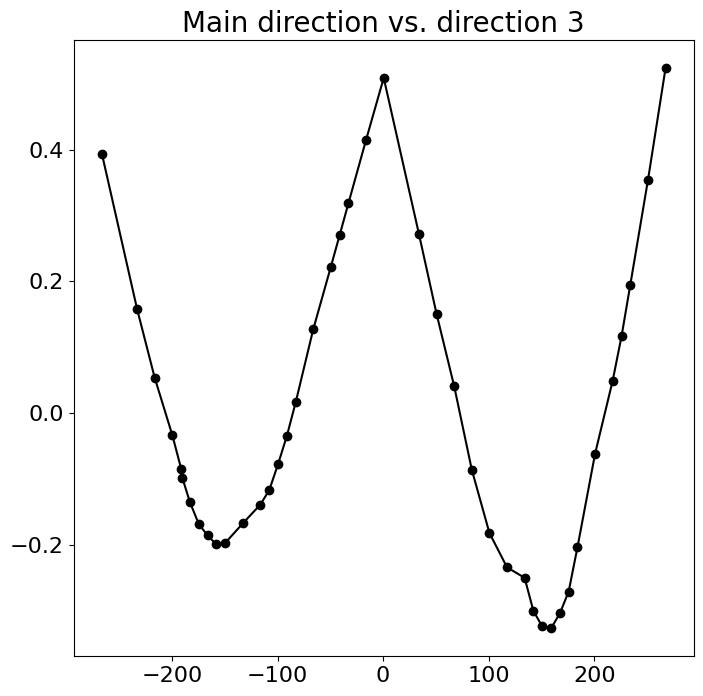

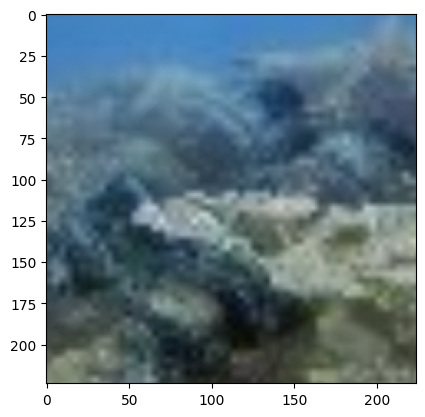

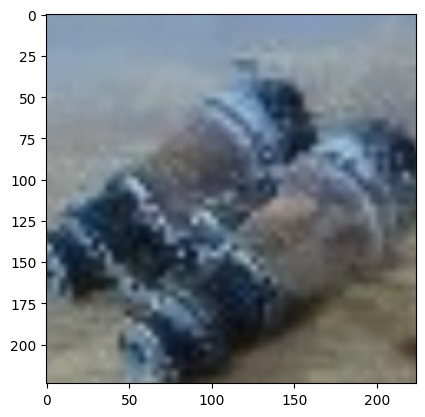

In [ ]:
visualize_path(path_fake_lemons_1_2)

#### Find and visualize the path between the second and third adversarial lemon images

In [ ]:
path_fake_lemons_2_3 = find_path(fake_lemon_2, fake_lemon_3, max_depth=20,
                                 n_test_pts=100, step_size=2e-2, linesearch=False, eps=0.1)
print(max_path_deviance(path_fake_lemons_2_3))

2.0542712211608887


In [ ]:
print(torch.norm(fake_lemon_2-fake_lemon_3))

tensor(533.6996)


Number of images in the path: 36


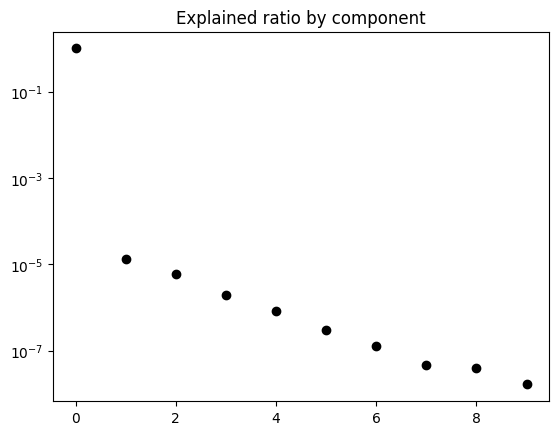

Number of PCA dimensions: 10


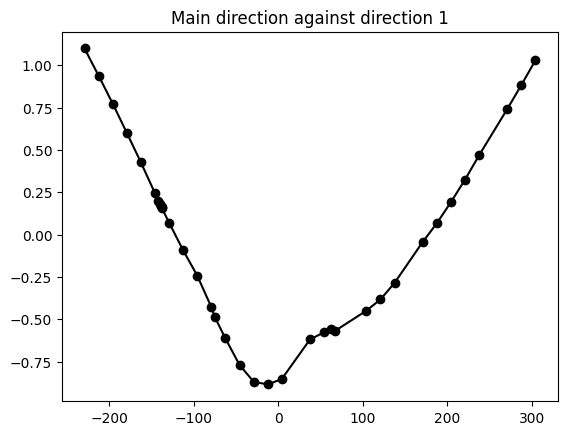

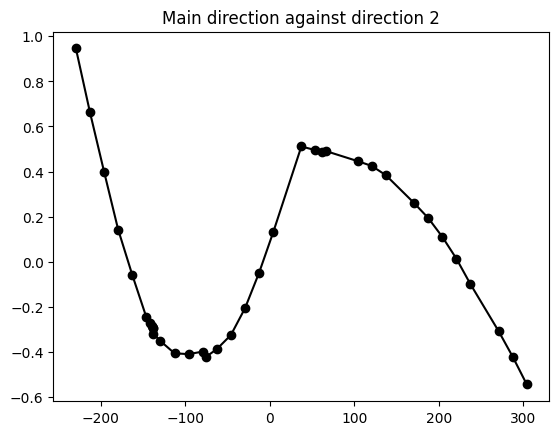

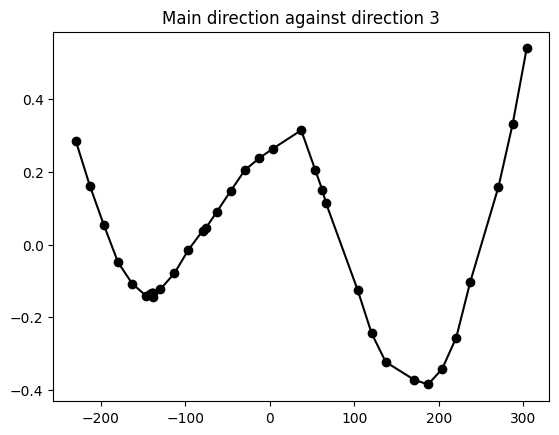

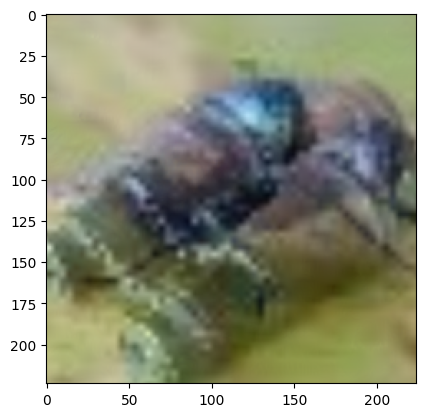

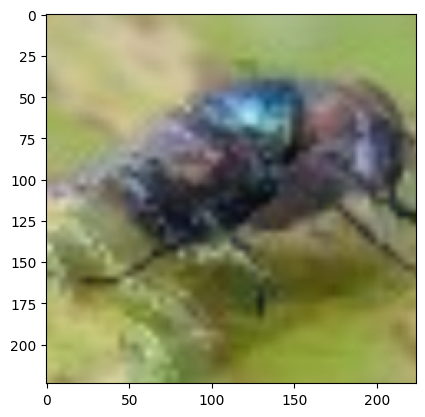

In [ ]:
visualize_path(path_fake_lemons_2_3)

## Repeat the experiments on several pairs of images to compare the deviation from the straight line between the case of natural and adversarial images

We want to compare the complexity of the paths between natural pairs images and adversarial pairs of images.

To do so, we use 100 test images and look for paths between pairs of eihter natural images or adversarial images.
We compute 3 metrics for each path, that are the number of points needed to represent the path, the maximum distance from the straight line of a point of the path, and ratio between this maximum and the length of the straight line.

In [ ]:
!unzip -d test_images 100_test_images.zip

Read the 100 test images and group them by labels

In [ ]:
filenames = os.listdir("test_images")
directory = "test_images/"

# Create a dictionnary to store lists of filenames of each label
img_dict = {}

for i, filename in enumerate(filenames):
    # Load the image and generate an adversarial example
    try:
      img = get_torch_image(directory + filename)
    except:
      filenames = filenames[:i] + filenames[i+1:]
      continue
    label = int(torch.argmax(predict(img)))

    if label in img_dict:
      img_dict[label].append(filename)
    else:
      img_dict[label] = [filename]


# Labels with at least images:
pair_labels = []

for label in img_dict:
    if len(img_dict[label]) > 1:
      print(len(img_dict[label]), categories[label])
      pair_labels.append(label)

2 thresher
2 tobacco shop
2 fox squirrel
2 steel arch bridge
2 earthstar
2 whiskey jug
2 spaghetti squash
2 chiton
3 monarch
2 rotisserie
4 magnetic compass
3 moving van
3 barn spider
2 platypus
2 Arabian camel
2 throne
2 seashore
2 gong


Create pairs of natural images with the same predicted classes, and find paths between them

In [ ]:
N_pairs_natural = len(pair_labels)
dataframe_nat = pd.DataFrame()
nb_not_found = 0

for i in range(N_pairs_natural):
    f_names = img_dict[pair_labels[i]]
    img_1 = get_torch_image(directory + f_names[0])
    img_2 = get_torch_image(directory + f_names[1])


    try:
        path = find_path(img_1, img_2, class_id=pair_labels[i], max_depth=20, step_size=1e-1)
    except:

        print("No path found for label {} and images {} and {}".format(categories(pair_labels[i]),
                                                                       f_names[0],
                                                                       f_names[1]))
        nb_not_found += 1
        continue

    dataframe_nat.at[i, "distance"] = torch.norm(img_1 - img_2).numpy()
    dataframe_nat.at[i, "nb_points"] = len(path)
    dataframe_nat.at[i, "max_dev"] = max_path_deviance(path)
    dataframe_nat.at[i, "norm_dev"] = dataframe_nat.at[i, "max_dev"] / dataframe_nat.at[i, "distance"]

    print("Path found for label", categories[pair_labels[i]])



Path found for label thresher
Path found for label tobacco shop
Path found for label fox squirrel
Path found for label steel arch bridge
Path found for label earthstar
Path found for label whiskey jug
Path found for label spaghetti squash
Path found for label chiton
Path found for label monarch
Path found for label rotisserie
Path found for label magnetic compass
Path found for label moving van
Path found for label barn spider
Path found for label platypus
Path found for label Arabian camel
Path found for label throne
Path found for label seashore
Path found for label gong


In [ ]:
dataframe_nat.to_csv("path_finding_natural.csv")
display(dataframe_nat)

distance  nb_points   max_dev      norm_dev
0    508.580933       21.0  0.187225  3.681319e-04
1    667.507751        9.0  0.225615  3.379956e-04
2    470.412476       16.0  0.172148  3.659506e-04
3    786.342529        2.0  0.003052  3.881062e-06
4    501.926117       19.0  0.477199  9.507350e-04
5    693.473328       22.0  0.516398  7.446542e-04
6    550.387207        6.0  0.018057  3.280837e-05
7    655.194397       13.0  0.437347  6.675077e-04
8    680.216675        2.0  0.000490  7.200429e-07
9    464.626770       11.0  0.073649  1.585112e-04
10   740.755615        2.0  0.003848  5.194604e-06
11   648.882935       33.0  0.311351  4.798262e-04
12  1035.166870        2.0  0.020027  1.934702e-05
13   430.598358       19.0  0.167128  3.881308e-04
14   561.749878       10.0  0.102799  1.829974e-04
15   535.496887        2.0  0.000855  1.595907e-06
16   331.458374        2.0  0.006744  2.034497e-05
17   661.291565        8.0  0.093367  1.411886e-04

Create pairs of adversarial images with the same predicted classes, and find paths between them

In [ ]:
N_pairs_adversarial = 30
dataframe_adv = pd.DataFrame()
nb_not_found = 0

for i in range(N_pairs_adversarial):
    # Select two images in the folder
    f_names = np.random.choice(filenames, replace=False, size=2)
    img_1 = get_torch_image(directory + f_names[0])
    img_2 = get_torch_image(directory + f_names[1])

    label_1 = int(torch.argmax(predict(img_1)))
    label_2 = int(torch.argmax(predict(img_2)))

    # Select a target label different from the two original ones
    target_label = np.random.randint(0, 1000)
    while target_label in [label_1, label_2]:
        target_label = np.random.randint(0, 1000)

    adv_1 = adversarial_image(img_1, target_label=target_label, step_size=5e-2,
                              linesearch=False)[0].cpu().detach()
    adv_2 = adversarial_image(img_2, target_label=target_label, step_size=5e-2,
                              linesearch=False)[0].cpu().detach()


    try:
        path = find_path(adv_1, adv_2, class_id=target_label, max_depth=20,
                         step_size=5e-2)
    except:
        print("No path found for label {} and images {} and {}".format(target_label,
                                                                       f_names[0],
                                                                       f_names[1]))
        nb_not_found += 1
        continue

    dataframe_adv.at[i, "target"] = target_label
    dataframe_adv.at[i, "distance"] = torch.norm(adv_1 - adv_2).numpy()
    dataframe_adv.at[i, "nb_points"] = len(path)
    dataframe_adv.at[i, "max_dev"] = max_path_deviance(path)
    dataframe_adv.at[i, "norm_dev"] = dataframe_adv.at[i, "max_dev"] / dataframe_adv.at[i, "distance"]

    print("Path found for label", target_label)

print("Paths not found for {} out of {}".format(nb_not_found, N_pairs_adversarial))

Path found for label 587
Path found for label 278
Path found for label 40
Path found for label 377
Path found for label 569
Path found for label 868
Path found for label 859
Path found for label 785
Path found for label 644
Path found for label 284
Path found for label 337
Path found for label 916
Path found for label 59
Path found for label 338
Path found for label 586
Path found for label 643
Path found for label 643
Path found for label 151
Path found for label 760
Path found for label 561
Path found for label 642
Path found for label 263
Path found for label 273
Path found for label 637
Path found for label 631
Path found for label 504
Path found for label 319
Path found for label 664
Path found for label 901
Path found for label 411
Paths not found for 0 out of 30


In [ ]:
dataframe_adv.to_csv("path_finding_adversarial.csv")
display(dataframe_adv)

target     distance  nb_points   max_dev  norm_dev
0    587.0   694.860901       82.0  2.155633  0.003102
1    278.0   474.214935       63.0  1.549945  0.003268
2     40.0   397.894287       60.0  2.115802  0.005317
3    377.0   554.679626       63.0  1.341244  0.002418
4    569.0   628.769470       71.0  1.373915  0.002185
5    868.0   562.187622       64.0  2.025341  0.003603
6    859.0   426.231049       62.0  1.633782  0.003833
7    785.0   609.099915       95.0  2.328261  0.003822
8    644.0   649.447205       73.0  1.655394  0.002549
9    284.0   731.822876       76.0  2.068790  0.002827
10   337.0   675.881165       32.0  0.685236  0.001014
11   916.0   707.686951       93.0  1.788047  0.002527
12    59.0   503.041229       57.0  2.059855  0.004095
13   338.0   479.336761       51.0  1.160282  0.002421
14   586.0   437.048431       64.0  0.971400  0.002223
15   643.0   751.047668       83.0  2.423713  0.003227
16   643.0   547.858948       65.0  1.545144  0.002820
17   151.0   796.410278       69.0  1.435584  0.001803
18   760.0  1096.674438       59.0  1.534456  0.001399
19   561.0   626.723022       55.0  1.581609  0.002524
20   642.0   615.070618       79.0  2.082938  0.003387
21   263.0   510.869751       64.0  1.333573  0.002610
22   273.0   732.231873       62.0  1.224330  0.001672
23   637.0   525.046143       93.0  2.279195  0.004341
24   631.0   467.515472       76.0  1.837260  0.003930
25   504.0   796.289185       82.0  2.404233  0.003019
26   319.0   472.020416       56.0  1.184049  0.002508
27   664.0   592.836426      105.0  2.680139  0.004521
28   901.0   548.934631       59.0  1.048810  0.001911
29   411.0   541.875061       96.0  2.754707  0.005084

### Comparison

We compare the metrics between the natural and adversarial image

We conclude that both in terms of number of points or deviance from the straight line, the paths between pairs of adversarial images are significantly more complex than the paths between pairs of natural images.

In [ ]:
print("Natural images:")
print("Normalized deviance =",
      np.mean(dataframe_nat["norm_dev"]), "+-",
      np.std(dataframe_nat["norm_dev"]))
print("Number of points =",
      np.mean(dataframe_nat["nb_points"]), "+-",
      np.std(dataframe_nat["nb_points"]))
print("Distance =",
      np.mean(dataframe_nat["distance"]), "+-",
      np.std(dataframe_nat["distance"]))

print("Adversarial images:")
print("Normalized deviance =",
      np.mean(dataframe_adv["norm_dev"]), "+-",
      np.std(dataframe_adv["norm_dev"]))
print("Number of points =",
      np.mean(dataframe_adv["nb_points"]), "+-",
      np.std(dataframe_adv["nb_points"]))
print("Distance =",
      np.mean(dataframe_adv["distance"]), "+-",
      np.std(dataframe_adv["distance"]))

Natural images:
Normalized deviance = 0.00027052896451969325 +- 0.0002820210326478143
Number of points = 11.055555555555555 +- 8.777953584737302
Distance = 606.8927035861545 +- 155.27109892672246
Adversarial images:
Normalized deviance = 0.002998642625812788 +- 0.001030348471477954
Number of points = 70.3 +- 15.597328831138576
Distance = 605.1202117919922 +- 142.41305526563434
